# **Modelling and Evaluation**

## Objectives

* Reduce size of model to improve intergration in streamlit dashboard
* Address potential of overfitting in previous model

## Inputs

* inputs/datasets/raw/cherry-leaves/train
* inputs/datasets/raw/cherry-leaves/validation
* inputs/datasets/raw/cherry-leaves/test
* image shape .pkl files

## Outputs

* Optimised CNN model development
* Trained model saved and exported to outputs folder
* Learning curve plots for model performance.
* Model evaluation with confusion matrix plot
* Test prediction on random single image file

## Additional Comments | Insights | Conclusions


---

# Setup

## Library Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shutil
import random
from matplotlib.image import imread
from IPython.display import Image
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.models import load_model

2025-01-31 18:21:33.566208: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-31 18:21:33.838890: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Set working directory

Change the working directory from its current folder to its parent folder

In [2]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-mildew-detector/jupyter_notebooks'

Make the parent of the current directory the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/cherry-mildew-detector'

## Set input directories

set paths to specific data folders required in notebook

In [5]:
raw_data_dir = 'inputs/datasets/raw/cherry-leaves'
train_data_dir = 'inputs/datasets/raw/cherry-leaves/train'
val_data_dir = 'inputs/datasets/raw/cherry-leaves/validation'
test_data_dir = 'inputs/datasets/raw/cherry-leaves/test'

print('the raw data directory is', raw_data_dir)
print('the training data directory is', train_data_dir)
print('the validation data directory is', val_data_dir)
print('the test data directory is', test_data_dir)


the raw data directory is inputs/datasets/raw/cherry-leaves
the training data directory is inputs/datasets/raw/cherry-leaves/train
the validation data directory is inputs/datasets/raw/cherry-leaves/validation
the test data directory is inputs/datasets/raw/cherry-leaves/test


## Set output directory

In [6]:
version = 'v2' # change version number for each iteration
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('This version is already available - create a new version if required.')
    pass
else:
    os.makedirs(name=file_path)

## Set labels

In [7]:
labels = os.listdir(test_data_dir)
print('Labels for images are', labels)

Labels for images are ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
image_128 = 'outputs/v1/image_shape_half.pkl'
image_50 = 'outputs/v1/image_shape_small.pkl'

---

# Data Augmentation

### Augment training image data and rescale validation and test image data



Define image size and batch size

In [9]:
# Allows size adjustment for tuning
IMG_SIZE = (50, 50) #can also be defined with any size eg.(128, 128)  
BATCH_SIZE = 32

Define data augmentation for training data

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    rotation_range=30,  # Random rotation up to 30 degrees
    width_shift_range=0.2,  # Shift width by 20%
    height_shift_range=0.2,  # Shift height by 20%
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Zoom into image
    horizontal_flip=True,  # Flip horizontally
    fill_mode='nearest'  # Fill empty space after transformations
)

Define rescaling for vallidation and test data

In [11]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

Load datasets

In [12]:
train_set = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'  # One-hot encoding for softmax
)

val_set = val_test_datagen.flow_from_directory(
    val_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_set = val_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

train_set.class_indices

Found 2944 images belonging to 2 classes.
Found 420 images belonging to 2 classes.
Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

---

# Model training

### Uses best CNN model architecture from top hyperparameter tuning result

Define image shape

In [13]:
image_shape = (50, 50, 3)  # Modify as needed or use .pkl file

Define best model

In [14]:
def create_tf_model():
    model = Sequential()

    # Input image shape
    model.add(Input(shape=image_shape))

    # First Conv2D layer with 32 filters
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Conv2D layer with 128 filters
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Dense layer with 128 dense units
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    # Dropout layer with dropout rate of 0.4
    model.add(Dropout(0.4))

    # Output layer (2 neurons, Softmax activation)
    model.add(Dense(2, activation='softmax'))

    # Adam optimiser has default 0.001 learning rate
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


Set early stop if not improving

In [15]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

### Fit model for model training

In [17]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          validation_data=val_set,
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/25


/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.6995 - loss: 0.5577 - val_accuracy: 0.9667 - val_loss: 0.0828
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9457 - loss: 0.1665 - val_accuracy: 1.0000 - val_loss: 0.0071
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9699 - loss: 0.0850 - val_accuracy: 0.9976 - val_loss: 0.0084
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9891 - loss: 0.0376 - val_accuracy: 0.9476 - val_loss: 0.1401
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9853 - loss: 0.0478 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9918 - loss: 0.0247 - val_accuracy: 1.0000 - val_loss: 4.1955e-04
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.9880 - loss: 0.0401 - val_accuracy: 0.9976 - val_loss: 0.0068
Epoch 8/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.9858 - loss: 0.0452 - val_accuracy: 0.9881 - val_loss

Save model

In [18]:
model.save(f'{file_path}/mildew_detector_model_{version}.h5')

Display model summary

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 22, 22, 128)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,982,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,062,216 (23.13 MB)

 Trainable params: 2,020,738 (7.71 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,041,478 (15.42 MB)

---

# Model Evaluation

## Model Learning Curve

Generate loss and accuracy plots

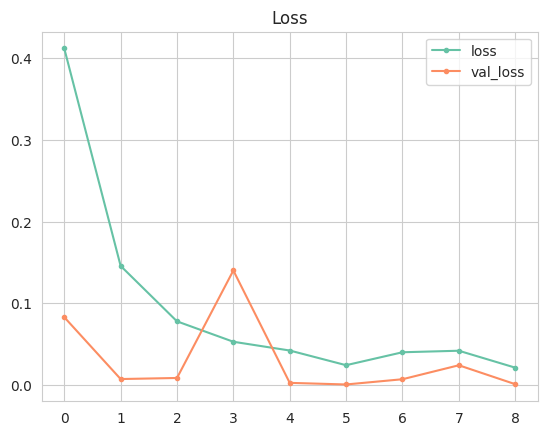

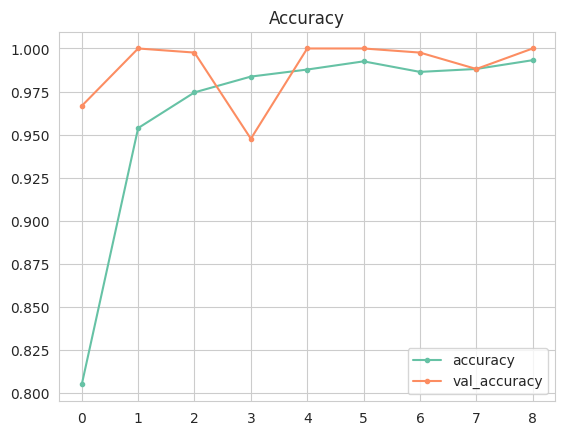

In [20]:
losses = pd.DataFrame(model.history.history)

# Set Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Plot Loss
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses_{version}.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")

# Plot Accuracy
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc_{version}.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Confusion Matrix

Generate confusion matrix

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


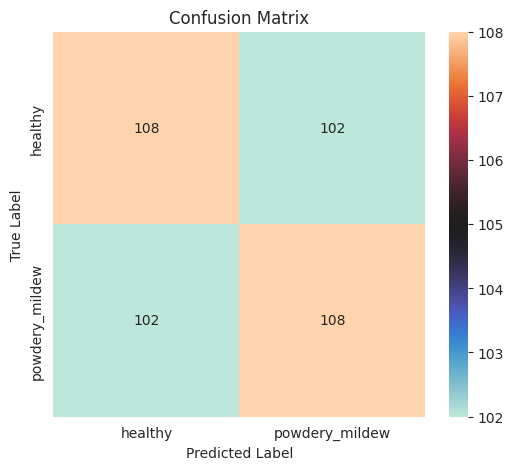

                precision    recall  f1-score   support

       healthy       0.51      0.51      0.51       210
powdery_mildew       0.51      0.51      0.51       210

      accuracy                           0.51       420
     macro avg       0.51      0.51      0.51       420
  weighted avg       0.51      0.51      0.51       420



In [22]:
# Get true labels and predictions
y_true = val_set.classes
y_pred = model.predict(val_set)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="icefire", xticklabels=val_set.class_indices.keys(), yticklabels=val_set.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig(f'{file_path}/confusion_matrix_{version}.png',
            bbox_inches='tight', dpi=150)
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=list(val_set.class_indices.keys())))

# Single Image test

## Evaluation

Load saved model

In [23]:
model = load_model(f'{file_path}/mildew_detector_model_{version}.h5')

Evaluate model on test set

In [24]:
evaluation = model.evaluate(test_set)

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9997 - loss: 0.0017


Save evaluation pickle

In [25]:
joblib.dump(value=evaluation,
            filename=f"{file_path}/evaluation_{version}.pkl")

['outputs/v2/evaluation_v2.pkl']

Predict on test set

In [31]:
result = model.predict(test_set, batch_size = BATCH_SIZE,verbose = 0)

y_pred = np.argmax(result, axis = 1)
y_true = test_set.labels

Generate classification report

In [33]:
# Generate classification report
class_report = classification_report(y_true, y_pred,target_names=labels)

# Define save path
report_save_path = f"{file_path}/classification_report_{version}.txt"

# Save to file
with open(report_save_path, "w") as f:
    f.write(class_report)

print(f"Classification report saved to: {report_save_path}")
print(class_report)

Classification report saved to: outputs/v2/classification_report_v2.txt
                precision    recall  f1-score   support

       healthy       0.52      0.52      0.52       422
powdery_mildew       0.52      0.51      0.51       422

      accuracy                           0.52       844
     macro avg       0.52      0.52      0.52       844
  weighted avg       0.52      0.52      0.52       844



Generate confusion matrix

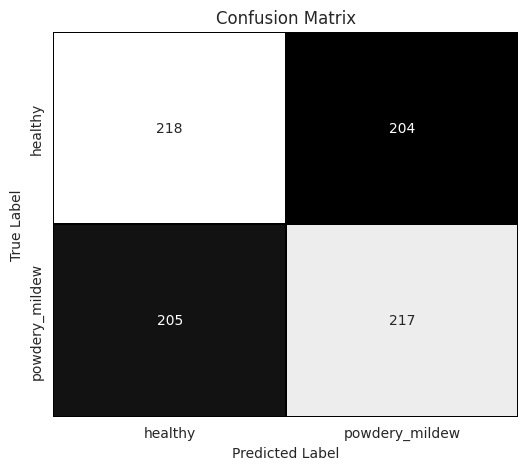

In [35]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black",
            fmt='.0f', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig(f'{file_path}/test_confusion_matrix_{version}.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Image test

Load a random image as PIL

Class indices mapping: {'healthy': 0, 'powdery_mildew': 1}
Image shape: (50, 50), Image mode: RGB


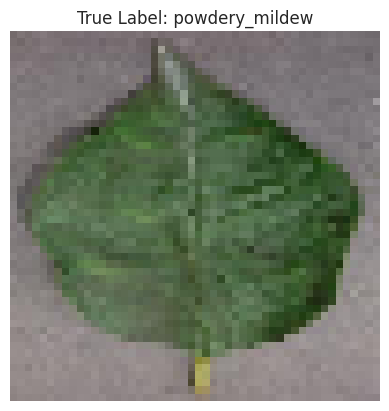

In [26]:
# Generate a random pointer between 0 and 421 (since index starts at 0)
pointer = random.randint(0, 421)  

# Verify class indices mapping
print("Class indices mapping:", train_set.class_indices)

# Load class labels
class_labels = list(train_set.class_indices.keys())  # ['healthy', 'powdery_mildew']

# Randomly select an image from one of the classes
label = random.choice(class_labels)  # Randomly choose between 'healthy' and 'powdery_mildew'

# Load the image
image_path = os.path.join(test_data_dir, label, os.listdir(os.path.join(test_data_dir, label))[pointer])
pil_image = image.load_img(image_path, target_size=image_shape, color_mode='rgb')

print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')

# Display image
plt.imshow(pil_image)
plt.title(f"True Label: {label}")
plt.axis('off')
plt.show()


Convert image to array and prepare for prediction

In [27]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0) / 255.0 
print(my_image.shape)

(1, 50, 50, 3)


Predict class probabilities

In [28]:
# Make prediction
pred_proba = model.predict(my_image)[0]  # Get softmax output (2 values)

# Interpret prediction
pred_class_idx = np.argmax(pred_proba)  # Get index of highest probability
pred_class = class_labels[pred_class_idx]  # Convert index to label

# Print results
print(f"True Label: {label}")
print(f"Predicted Class: {pred_class} with probability {pred_proba[pred_class_idx]:.4f}")
print(f"Raw prediction output: {pred_proba}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
True Label: powdery_mildew
Predicted Class: powdery_mildew with probability 0.9997
Raw prediction output: [3.3991697e-04 9.9966013e-01]


---

# Conclusions and Next Steps

Conclusions: 
* Version 2: 
    - same architecture as V1 model but with 50 x 50 image size. 
    - High accuracy (99%) but till potentially overfitting according to confusion matrix.
* Version 3: 
    - Second best hyperparameter settings from tuning result with 50 x 50 image size.

Next steps:
* Build streamlit dashboard to enable client to use model for mildew prediction